Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data...
✅ Ready to train on 383560 complaints.

Step 1/2: Vectorizing (Full Vocabulary)...
✅ Vocabulary Size: 609351 words (Previously was 5,000)

Step 2/2: Training LinearSVC (The 'Strict' Model)...
✅ Model trained successfully!

--- MODEL PERFORMANCE ---
              precision    recall  f1-score   support

        High       0.90      0.88      0.89     30555
         Low       0.80      0.80      0.80     12919
      Medium       0.84      0.86      0.85     33238

    accuracy                           0.86     76712
   macro avg       0.85      0.85      0.85     76712
weighted avg       0.86      0.86      0.86     76712



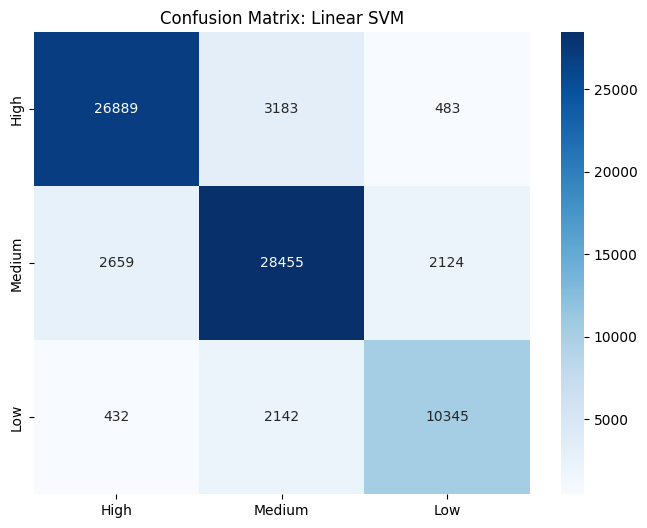


Saving artifacts...
🚀 Saved to /content/drive/My Drive/Smart Complaint Prioritizer/models


In [3]:
# --- 1. SETUP ---
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
PROJECT_PATH = "/content/drive/My Drive/Smart Complaint Prioritizer"
INPUT_FILE = f"{PROJECT_PATH}/data/processed/complaints_with_features.csv"
MODEL_DIR = f"{PROJECT_PATH}/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# --- 2. LOAD DATA ---
print("Loading data...")
df = pd.read_csv(INPUT_FILE)
df = df.dropna(subset=['cleaned_narrative', 'priority'])
print(f"✅ Ready to train on {len(df)} complaints.")

# --- 3. SPLIT DATA ---
X = df['cleaned_narrative']
y = df['priority']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. VECTORIZATION (NO MORE 5000 LIMIT) ---
print("\nStep 1/2: Vectorizing (Full Vocabulary)...")

# min_df=5: Keep ANY word that appears at least 5 times in the whole dataset.
# ngram_range=(1,2): Learn "not authorized" as a single unit, not just "authorized".
tfidf = TfidfVectorizer(min_df=5, stop_words='english', ngram_range=(1,2))

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print(f"✅ Vocabulary Size: {len(tfidf.vocabulary_)} words (Previously was 5,000)")

# --- 5. MODEL TRAINING (HEAVY DUTY SVM) ---
print("\nStep 2/2: Training LinearSVC (The 'Strict' Model)...")

# LinearSVC is faster and stricter for text.
# We wrap it in CalibratedClassifierCV to get probabilities (confidence scores).
svm = LinearSVC(class_weight='balanced', random_state=42, dual='auto', max_iter=2000)
model = CalibratedClassifierCV(svm)

model.fit(X_train_vec, y_train)
print("✅ Model trained successfully!")

# --- 6. EVALUATION ---
print("\n--- MODEL PERFORMANCE ---")
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred, labels=['High', 'Medium', 'Low'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['High', 'Medium', 'Low'], yticklabels=['High', 'Medium', 'Low'])
plt.title('Confusion Matrix: Linear SVM')
plt.show()

# --- 7. SAVE ---
print("\nSaving artifacts...")
joblib.dump(model, f"{MODEL_DIR}/priority_model.pkl")
joblib.dump(tfidf, f"{MODEL_DIR}/tfidf_vectorizer.pkl")
print(f"🚀 Saved to {MODEL_DIR}")